In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Import All Data

In [189]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")
frames = [train_df, val_df, test_df]
full_df = pd.concat(frames, sort=False)
full_df = full_df.reset_index(drop=True)

mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)

In [184]:
mean_std

,mean,std
price,120.097102,68.198942
latitude,43.677492,0.046110
longitude,-79.398326,0.059359
property_type,2.819879,1.844364
room_type,0.340686,0.495957
accommodates,3.053679,1.762132
bathrooms,1.200374,0.459320
bedrooms,1.270343,0.765102
beds,1.625366,0.961066
cancellation_policy,7.400940,5.685699


In [214]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        return {"sample": sample, "label": label}
#print(train_df)
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=1)

# Visualize One Sample 

In [17]:
pd.set_option('display.max_rows', 500)
full_df.head(1).transpose()

,0
id,8031392
last_scraped,2019-06-05
host_is_superhost,0
latitude,-0.396491
longitude,0.215068
property_type,-0.444532
room_type,-0.686927
accommodates,-0.597957
bathrooms,-0.436242
bedrooms,-0.353343


# Unstandardize Data

In [25]:
for i in mean_std.index:
    full_df[i] = full_df[i]*mean_std["std"][i] + mean_std["mean"][i]

In [29]:
for i in ["property_type", "facilities_count", "house_rules_count"]:
    full_df[i] = full_df[i].round()

# Map of Prices

In [34]:
print(full_df["latitude"].describe())
print(full_df["longitude"].describe())

count    209615.000000
mean         43.677492
std           0.046110
min          43.586710
25%          43.644730
50%          43.661217
75%          43.689460
max          43.847487
Name: latitude, dtype: float64
count    209615.000000
mean        -79.398326
std           0.059359
min         -79.632630
25%         -79.424340
50%         -79.397650
75%         -79.378841
max         -79.123400
Name: longitude, dtype: float64


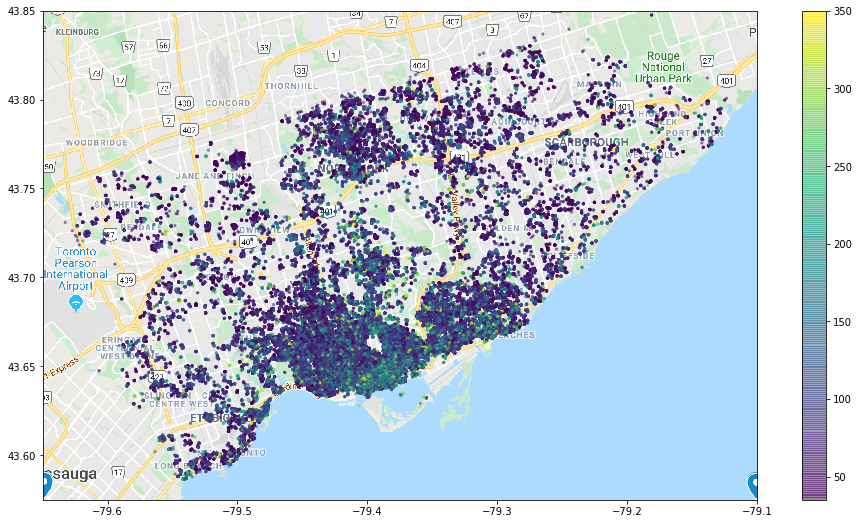

In [171]:
BBox = [-79.650, -79.100, 43.575, 43.850] # define longitude/latitude bounding box
toronto_map = plt.imread('map.png') # load image of toronto map

fig, ax = plt.subplots(figsize=(16, 9)) # create plot
im = ax.scatter(full_df["longitude"], full_df["latitude"], alpha=0.5, c=full_df["price"], s=5) # scatter plot
fig.colorbar(im, ax=ax) # create colour bar of price

ax.set_xlim(BBox[0], BBox[1]) # set latitude bounds
ax.set_ylim(BBox[2], BBox[3]) # set longitude bounds

ax.imshow(toronto_map, zorder=0, extent=BBox, aspect='auto') #show plot

In [172]:
fig.savefig("price_map2.png", dpi=300)

# Map of Prices, Downtown Only

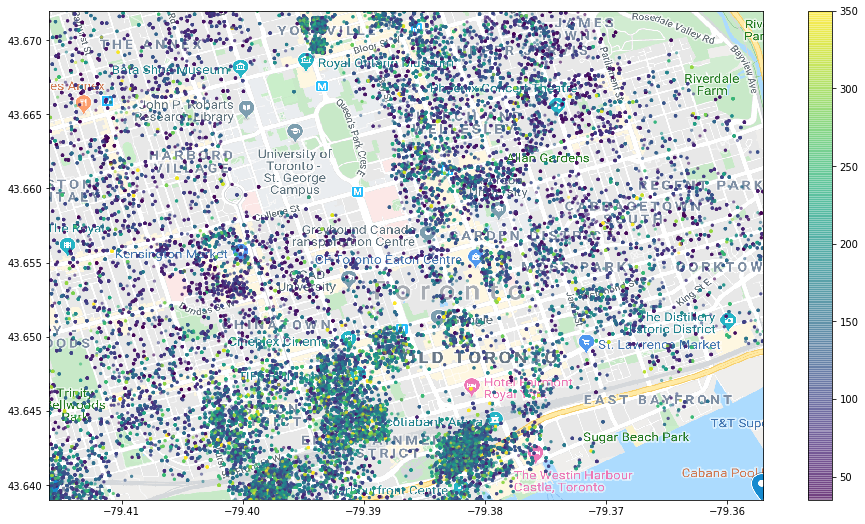

In [181]:
BBox = [-79.416, -79.357, 43.639, 43.672] # define longitude/latitude bounding box
toronto_map = plt.imread('map3.png') # load image of toronto map

fig, ax = plt.subplots(figsize=(16, 9)) # create plot
im = ax.scatter(full_df["longitude"], full_df["latitude"], alpha=0.5, c=full_df["price"], s=5) # scatter plot
fig.colorbar(im, ax=ax) # create colour bar of price

ax.set_xlim(BBox[0], BBox[1]) # set latitude bounds
ax.set_ylim(BBox[2], BBox[3]) # set longitude bounds

ax.imshow(toronto_map, zorder=0, extent=BBox, aspect='auto') #show plot

# Histogram of Prices

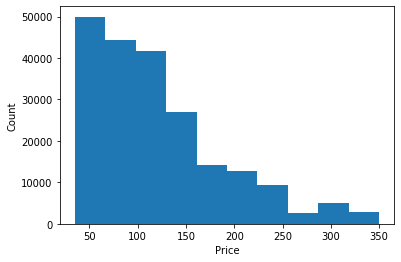

In [113]:
plt.hist(full_df["price"], bins=10)
plt.xlabel("Price")
plt.ylabel("Count")
plt.savefig("price_dist.png")

# Map of Property Types

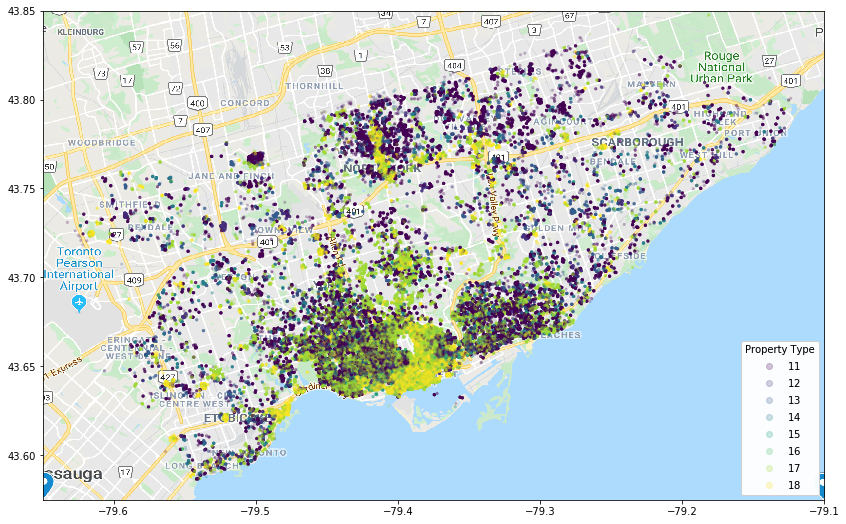

In [179]:
BBox = [-79.650, -79.100, 43.575, 43.850] # define longitude/latitude bounding box
toronto_map = plt.imread('map.png') # load image of toronto map

fig, ax = plt.subplots(figsize=(14, 9)) # create plot

property_types = {
    1:11, #house
    3:12, #townhouse
    0:13, #bungalow
    7:14, #guest suite
    4:15, # loft
    6:16, # serv apt
    2:17, # apart
    5:18, #condo
    
}

types = full_df["property_type"].apply(lambda x: property_types[x])

im = ax.scatter(full_df["longitude"], full_df["latitude"], alpha=0.2, c=types, s=5) # scatter plot
legend1 = ax.legend(*im.legend_elements(), loc="lower right", title="Property Type")
ax.add_artist(legend1)

ax.set_xlim(BBox[0], BBox[1]) # set latitude bounds
ax.set_ylim(BBox[2], BBox[3]) # set longitude bounds

ax.imshow(toronto_map, zorder=0, extent=BBox, aspect='auto') #show plot

In [180]:
fig.savefig("property_map.png", dpi=300)

# Plot Error Map

In [215]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*3)
        self.layer2 = nn.Linear(41*3, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*2)
        self.layer5 = nn.Linear(41*2, 41*1)
        self.layer6 = nn.Linear(41*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer5(x))
        return self.layer6(x)

In [216]:
model = airbnb_net()
checkpoint = torch.load("../test/Brian/nov22_test01/final/checkpoint_final.tar")
model = airbnb_net()
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [217]:
errors = torch.tensor([])
for i, data in enumerate(test_loader):
    sample = data["sample"].float()
    label = data["label"].float().view(-1)
    output = model(sample).view(-1)
    error = abs(label-output)*mean_std["std"]["price"]
    errors = torch.cat((errors, error))
    print(errors.shape)

torch.Size([1000])
torch.Size([2000])
torch.Size([3000])
torch.Size([4000])
torch.Size([5000])
torch.Size([6000])
torch.Size([7000])
torch.Size([8000])
torch.Size([9000])
torch.Size([10000])
torch.Size([11000])
torch.Size([12000])
torch.Size([13000])
torch.Size([14000])
torch.Size([15000])
torch.Size([16000])
torch.Size([17000])
torch.Size([18000])
torch.Size([19000])
torch.Size([20000])
torch.Size([20961])


In [224]:
test_df["error"] = errors.detach().numpy()
for i in mean_std.index:
    test_df[i] = test_df[i]*mean_std["std"][i] + mean_std["mean"][i]

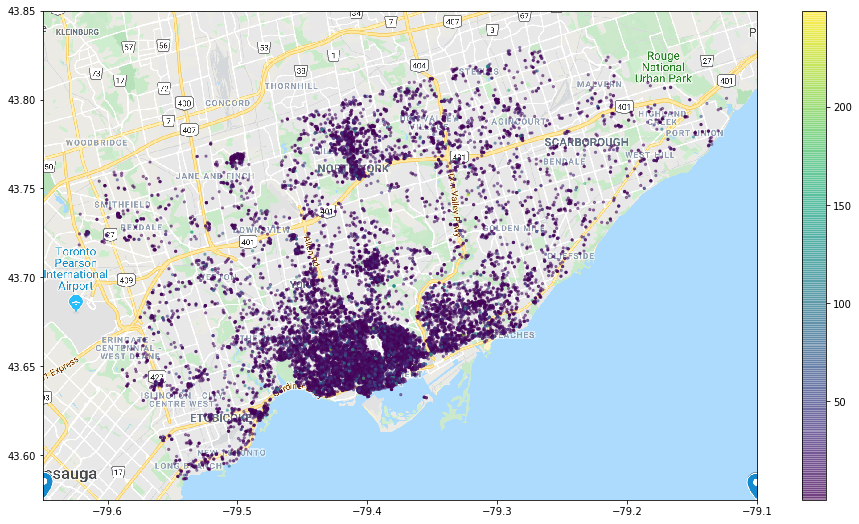

In [225]:
BBox = [-79.650, -79.100, 43.575, 43.850] # define longitude/latitude bounding box
toronto_map = plt.imread('map.png') # load image of toronto map

fig, ax = plt.subplots(figsize=(16, 9)) # create plot
im = ax.scatter(test_df["longitude"], test_df["latitude"], alpha=0.5, c=test_df["error"], s=5) # scatter plot
fig.colorbar(im, ax=ax) # create colour bar of price

ax.set_xlim(BBox[0], BBox[1]) # set latitude bounds
ax.set_ylim(BBox[2], BBox[3]) # set longitude bounds

ax.imshow(toronto_map, zorder=0, extent=BBox, aspect='auto') #show plot

In [227]:
fig.savefig("error_map.png", dpi=300)